# Лабораторна робота: Побудова та оцінка класифікаційних моделей з використанням ансамблів

# Мета роботи

Вивчити методи побудови класифікаційних моделей, попередньої обробки даних, використання ансамблевих методів та оцінки моделей.

In [348]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler
from sklearn.utils import all_estimators
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Вибір навчального набору даних

- Оберіть навчальний набір даних для класифікатора на свій розсуд (наприклад, Kaggle Datasets)
- Завантажте та досліджуйте обраний набір даних

In [349]:
wines = pd.read_csv(
      "datasets/winequality-red.csv", 
      names=[
            "Fixed acidity",
            "Volatile acidity",
            "Citric acid",
            "Residual sugar",
            "Chlorides",
            "Free sulfur dioxide",
            "Total sulfur dioxide",
            "Density",
            "pH",
            "Sulphates",
            "Alcohol",
            "Quality",
      ]
)

wines

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free sulfur dioxide,Total sulfur dioxide,Density,pH,Sulphates,Alcohol,Quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [350]:
correlation_matrix = wines.corr()

correlation_matrix

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free sulfur dioxide,Total sulfur dioxide,Density,pH,Sulphates,Alcohol,Quality
Fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
Volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
Citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
Residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
Chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
Free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
Total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
Density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
Sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


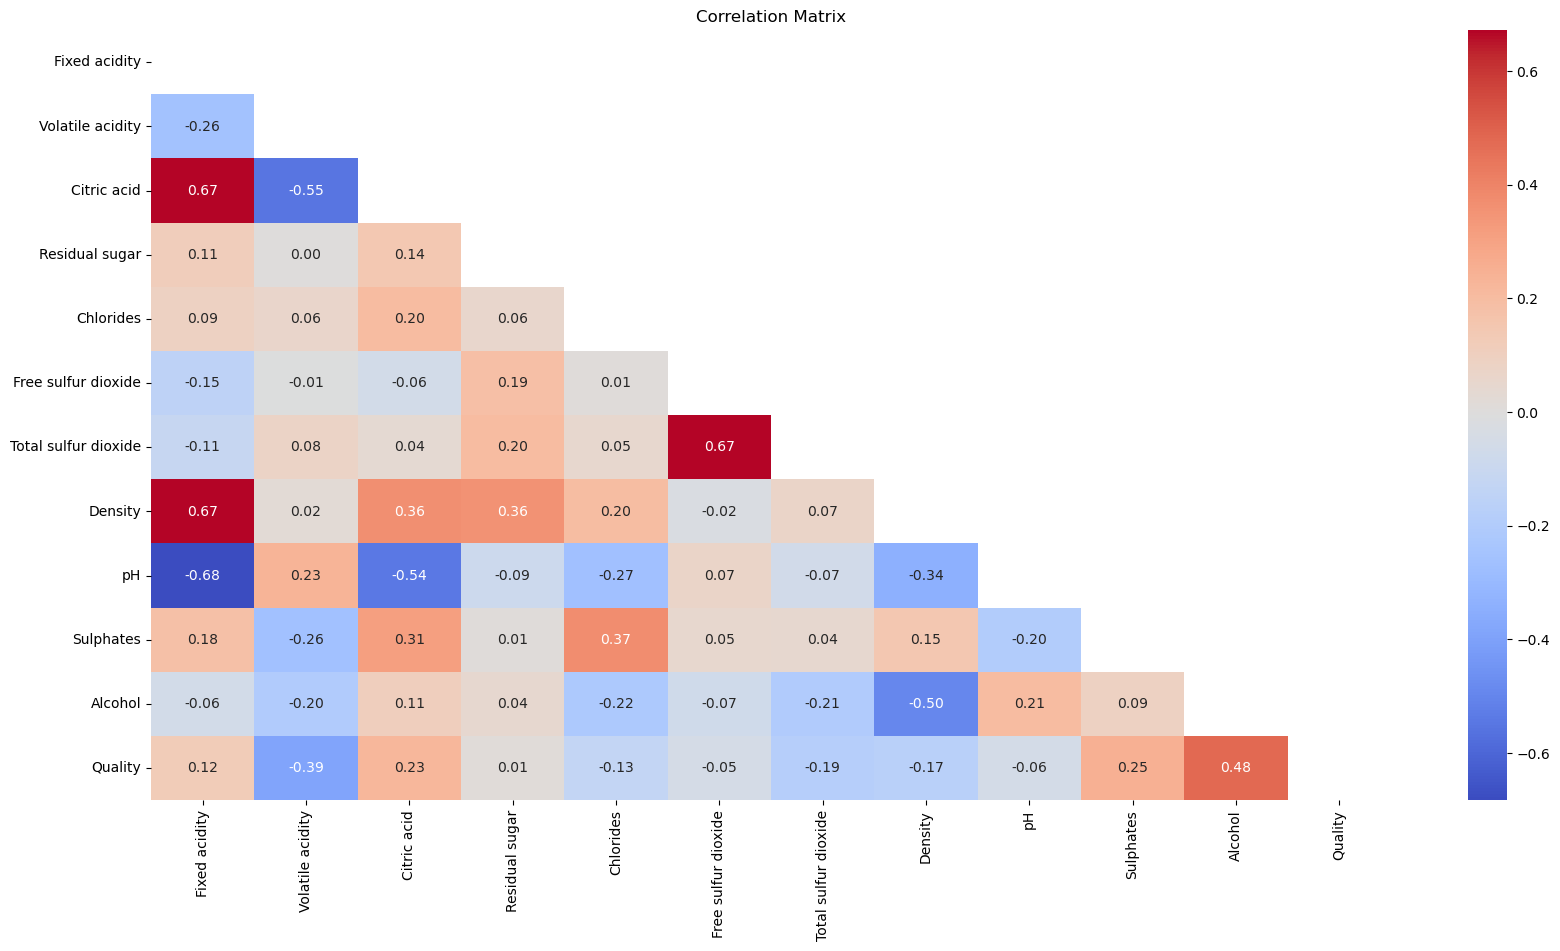

In [351]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Попередня обробка даних

- Виконайте очищення даних (обробка пропущених значень, видалення дублікатів тощо)
- Виконайте нормалізацію або стандартизацію числових змінних (якщо необхідно)
- Виконайте перетворення категоріальних змінних (наприклад, One-Hot Encoding)
- Збалансуйте набір даних
- Розділіть набір даних на навчальну та тестову вибірки

In [352]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fixed acidity         1599 non-null   float64
 1   Volatile acidity      1599 non-null   float64
 2   Citric acid           1599 non-null   float64
 3   Residual sugar        1599 non-null   float64
 4   Chlorides             1599 non-null   float64
 5   Free sulfur dioxide   1599 non-null   float64
 6   Total sulfur dioxide  1599 non-null   float64
 7   Density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   Sulphates             1599 non-null   float64
 10  Alcohol               1599 non-null   float64
 11  Quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [353]:
wines_features = wines.drop(columns=['Quality'])
wines_target = wines['Quality']

In [354]:
QUALITY_THRESHOLD = 6
labelEncoder = LabelEncoder()

wines_conditions = [
    (wines['Quality'] < QUALITY_THRESHOLD),
    (wines['Quality'] == QUALITY_THRESHOLD),
    (wines['Quality'] > QUALITY_THRESHOLD),
]
wines_quality = ['Bad', 'Great', 'Good']

wines_target = np.select(wines_conditions, wines_quality)

wines_target

array(['Bad', 'Bad', 'Bad', ..., 'Great', 'Bad', 'Great'], dtype='<U5')

In [355]:
labelEncoder = LabelEncoder()

wines_target_encoded = labelEncoder.fit_transform(wines_target.astype(str))

wines_target_encoded

array([0, 0, 0, ..., 2, 0, 2])

In [356]:
scaler = MinMaxScaler() #StandardScaler()

scaler.fit_transform(wines_features)
wines_features_normalized = pd.DataFrame(scaler.fit_transform(wines_features), columns=wines_features.columns)

wines_features_normalized

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free sulfur dioxide,Total sulfur dioxide,Density,pH,Sulphates,Alcohol
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
...,...,...,...,...,...,...,...,...,...,...,...
1594,0.141593,0.328767,0.08,0.075342,0.130217,0.436620,0.134276,0.354626,0.559055,0.149701,0.323077
1595,0.115044,0.294521,0.10,0.089041,0.083472,0.535211,0.159011,0.370778,0.614173,0.257485,0.430769
1596,0.150442,0.267123,0.13,0.095890,0.106845,0.394366,0.120141,0.416300,0.535433,0.251497,0.400000
1597,0.115044,0.359589,0.12,0.075342,0.105175,0.436620,0.134276,0.396476,0.653543,0.227545,0.276923


# Побудова класифікаційних моделей

Побудуйте декілька класифікаційних моделей, таких як:

- Логістична регресія
- Дерево рішень
- Підтримковий векторний класифікатор (SVC)
- K-найближчих сусідів (KNN)
- Наївний баєсів класифікатор
- etc

Навчіть моделі на навчальній вибірці та протестуйте на тестовій вибірці

# Побудова ансамблів моделей

Побудуйте ансамбль моделей з використанням методів:

- Boosting (наприклад, AdaBoost, Gradient Boosting)
- Bagging (наприклад, Random Forest)
- Stacking (поєднання декількох базових моделей з використанням метамоделі)

Навчіть ансамблеві моделі на навчальній вибірці та протестуйте на тестовій вибірці.


# Оцінка моделей
Для кожного класифікатора та ансамблю побудуйте та оцініть:

- Матрицю невідповідностей (confusion matrix)
- Точність (accuracy)
- Прецизію (precision)
- Повторюваність (recall)
- F1-оцінку (F1-score)

In [357]:
wines_target_encoded.shape, wines_features_normalized.shape

((1599,), (1599, 11))

In [358]:
classifiers = all_estimators(type_filter='classifier')
stratifiedKFold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

len(classifiers)

44

In [369]:
N_SPLITS = 5
RANDOM_STATE = 42
confusion_matrixes = {}
summury = pd.DataFrame(columns=['Name', 'Score', 'Precision Score', 'Recall Score', 'F1 Score'])

for index, data in enumerate(classifiers):
      try:
            name, Classifier = data
            params = {}

            if name in [
                  'FixedThresholdClassifier',
                  'TunedThresholdClassifierCV',
                  'CategoricalNB',
                  'SelfTrainingClassifier',
                  'MultiOutputClassifier',
                  'ClassifierChain'
            ]:
                  continue

            elif name == 'MLPClassifier':
                  params['early_stopping'] = True
                  params['n_iter_no_change'] = 10
                  params['validation_fraction'] = 0.1
            elif name == 'ClassifierChain':
                  params['base_estimator'] = LogisticRegression()
            elif name in [
                  'FixedThresholdClassifier',
                  'FixedThresholdClassifier',
                  'MultiOutputClassifier',
                  'OneVsOneClassifier',
                  'OneVsRestClassifier',   
                  'OutputCodeClassifier',
                  'TunedThresholdClassifierCV',
            ]:
                  params['estimator'] = LogisticRegression()
            elif name in ['VotingClassifier', 'StackingClassifier']:
                  params['estimators'] = [('lr', LogisticRegression())]
            elif name == 'NuSVC':
                  params['nu'] = 0.1

            classifier = Classifier(**params)
            scores = cross_val_score(classifier, wines_features_normalized, wines_target_encoded, cv=stratifiedKFold, scoring='accuracy')
            classifier.fit(wines_features_normalized, wines_target_encoded)
            prediction = cross_val_predict(classifier, wines_features_normalized, wines_target_encoded, cv=stratifiedKFold)
            
            classifier_score = np.mean(scores)
            classifier_confusion_matrix = confusion_matrix(wines_target_encoded, prediction)

            # 'macro',  'micro', 'weighted'
            classifier_f1_score = f1_score(wines_target_encoded, prediction, average='weighted')
            classifier_recall_score = recall_score(wines_target_encoded, prediction, average='weighted')
            classifier_precision_score = precision_score(wines_target_encoded, prediction, average='weighted', zero_division=0)

            summury.loc[len(summury)] = {
                  'Name': name,
                  'Score': classifier_score,
                  'Precision Score': classifier_precision_score,
                  'Recall Score': classifier_recall_score,
                  'F1 Score': classifier_f1_score
            }

            confusion_matrixes[name] = classifier_confusion_matrix
            
      except Exception as e:
            print(f"Error with {name}: {e}")
            continue

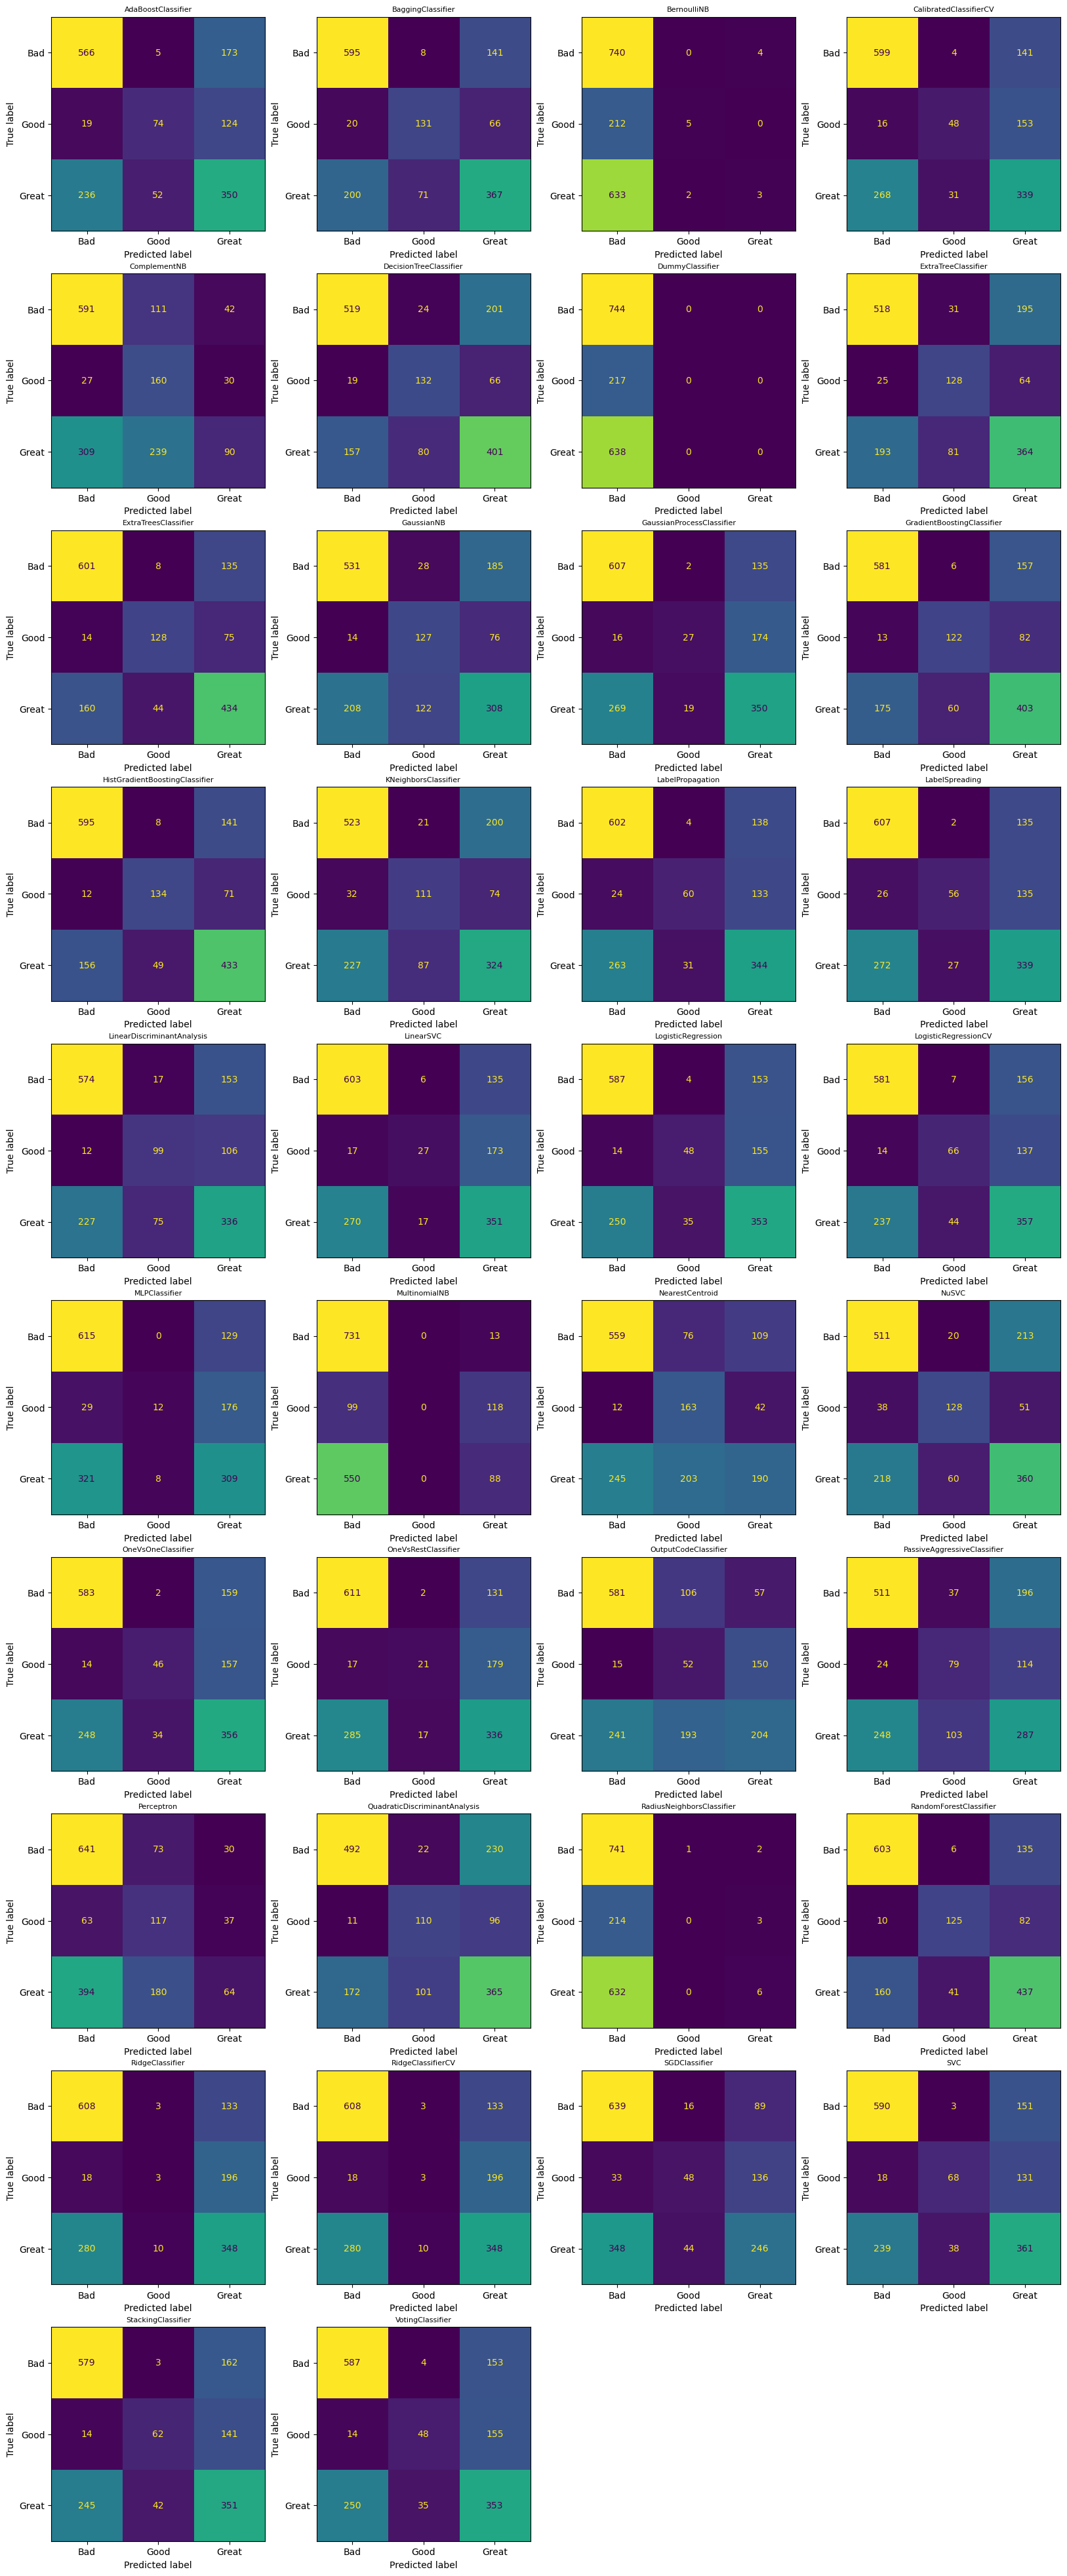

In [370]:
fig, axes = plt.subplots(10, 4, figsize=(20, 50))
axes = axes.flatten()

for index, (name, classifier_confusion_matrix) in enumerate(confusion_matrixes.items()):
      disp = ConfusionMatrixDisplay(confusion_matrix=classifier_confusion_matrix, display_labels=labelEncoder.classes_)
      disp.plot(ax=axes[index], colorbar=False)
      axes[index].set_title(name, fontsize=8)

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.show()

In [371]:
summury

,Name,Score,Precision Score,Recall Score,F1 Score
0,AdaBoostClassifier,0.619130,0.613275,0.619137,0.611625
1,BaggingClassifier,0.697927,0.679457,0.683552,0.680069
2,BernoulliNB,0.467796,0.485169,0.467792,0.305447
3,CalibratedClassifierCV,0.616626,0.607804,0.616635,0.598874
4,ComplementNB,0.525937,0.560884,0.525954,0.478638
5,DecisionTreeClassifier,0.655384,0.662886,0.657911,0.659740
6,DummyClassifier,0.465290,0.216496,0.465291,0.295498
7,ExtraTreeClassifier,0.636628,0.632975,0.631645,0.632075
8,ExtraTreesClassifier,0.726687,0.726221,0.727330,0.725849
9,GaussianNB,0.604126,0.606313,0.604128,0.603496
